#Lab 10: Deep Learning For Sequential Data

---


## Future total sales of pizza<br>
In this lab, we will predict the future total sales of pizza based on the sequential transactions by using LSTM.<br><br>

This pizza sales dataset make up 12 relevant features:<br>

order_id: Unique identifier for each order placed by a table<br>
order_details_id: Unique identifier for each pizza placed within each order (pizzas of the same type and size are kept in the same row, and the quantity increases)<br>
pizza_id: Unique key identifier that ties the pizza ordered to its details, like size and price<br>
quantity: Quantity ordered for each pizza of the same type and size
order_date: Date the order was placed (entered into the system prior to cooking & serving)<br>
order_time: Time the order was placed (entered into the system prior to cooking & serving)<br>
unit_price: Price of the pizza in USD<br>
total_price: unit_price * quantity<br>
pizza_size: Size of the pizza (Small, Medium, Large, X Large, or XX Large)<br>
pizza_type: Unique key identifier that ties the pizza ordered to its details, like size and price<br>
pizza_ingredients: ingredients used in the pizza as shown in the menu (they all include Mozzarella Cheese, even if not specified; and they all include Tomato Sauce, unless another sauce is specified)<br>
pizza_name: Name of the pizza as shown in the menu<br>

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from itertools import chain
import torch
import torch.nn as nn
import torch.optim as optim

###1. Upload and clean data

In [ ]:
# Read data
PizzaSales = pd.read_csv("/content/drive/MyDrive/DL_data/PizzaSales.csv")
PizzaSales

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/15,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/15,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/15,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/15,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/15,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,12/31/15,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,48617,21348,four_cheese_l,1,12/31/15,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,48618,21348,napolitana_s,1,12/31/15,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619,21349,mexicana_l,1,12/31/15,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [ ]:
# Show the head rows of a data frame
PizzaSales.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/15,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/15,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/15,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/15,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/15,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [ ]:
# Examine variable type
PizzaSales.dtypes

order_details_id       int64
order_id               int64
pizza_id              object
quantity               int64
order_date            object
order_time            object
unit_price           float64
total_price          float64
pizza_size            object
pizza_category        object
pizza_ingredients     object
pizza_name            object
dtype: object

In [ ]:
# Examine data size
PizzaSales.shape

(48620, 12)

###2. Simple data exploration

In [ ]:
# Convert order_date column to datetime
PizzaSales['order_date'] = pd.to_datetime(PizzaSales['order_date'])

In [ ]:
# Exam the number of pizza sold by month
PizzaSales['order_month'] =pd.DatetimeIndex(PizzaSales['order_date']).month
PizzaSales.loc[(PizzaSales['order_month'] ==1), 'order_month'] = 'January'
PizzaSales.loc[(PizzaSales['order_month'] ==2), 'order_month'] = 'February'
PizzaSales.loc[(PizzaSales['order_month'] ==3), 'order_month'] = 'March'
PizzaSales.loc[(PizzaSales['order_month'] ==4), 'order_month'] = 'April'
PizzaSales.loc[(PizzaSales['order_month'] ==5), 'order_month'] = 'May'
PizzaSales.loc[(PizzaSales['order_month'] ==6), 'order_month'] = 'June'
PizzaSales.loc[(PizzaSales['order_month'] ==7), 'order_month'] = 'July'
PizzaSales.loc[(PizzaSales['order_month'] ==8), 'order_month'] = 'August'
PizzaSales.loc[(PizzaSales['order_month'] ==9), 'order_month'] = 'September'
PizzaSales.loc[(PizzaSales['order_month'] ==10), 'order_month'] = 'October'
PizzaSales.loc[(PizzaSales['order_month'] ==11), 'order_month'] = 'November'
PizzaSales.loc[(PizzaSales['order_month'] ==12), 'order_month'] = 'December'
PizzaSales['order_month'].value_counts()

July         4301
May          4239
March        4186
November     4185
January      4156
August       4094
April        4067
June         4025
February     3892
December     3859
September    3819
October      3797
Name: order_month, dtype: int64

In [ ]:
# Exam the number of pizza sold by day
PizzaSales["Dayofweek"] = PizzaSales['order_date'].dt.day_name()
PizzaSales["Dayofweek"].value_counts()

Friday       8106
Saturday     7355
Thursday     7323
Wednesday    6797
Tuesday      6753
Monday       6369
Sunday       5917
Name: Dayofweek, dtype: int64

In [ ]:
# Examine the number of pizza sold by hour
PizzaSales[['Hour','Minute', 'Second']]= PizzaSales['order_time'].str.split(":",expand=True)
PizzaSales["Hour"].value_counts()

12    6543
13    6203
18    5359
17    5143
19    4350
16    4185
14    3521
20    3487
15    3170
11    2672
21    2528
22    1370
23      68
10      17
9        4
Name: Hour, dtype: int64

In [ ]:
# Examine the number of pizza sold by pizza id
PizzaSales["pizza_id"].value_counts()

big_meat_s        1811
thai_ckn_l        1365
five_cheese_l     1359
four_cheese_l     1273
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: pizza_id, Length: 91, dtype: int64

In [ ]:
# Examine the number of pizza sold by pizza size
PizzaSales["pizza_size"].value_counts()

L      18526
M      15385
S      14137
XL       544
XXL       28
Name: pizza_size, dtype: int64

In [ ]:
PizzaSales['order_id'].max()

21350

In [ ]:
# Examine the average order value
PizzaSales['total_price'].agg('sum')/PizzaSales['order_id'].max()

38.30726229508197

###3. Partition the data set for pizza sales prediction

In [ ]:
# Organize sales by date
sales_by_date = PizzaSales.groupby(['order_date']).sum()
sales_by_date["Dayofweek"] = sales_by_date.index.day_name()
sales_by_date = sales_by_date[['quantity','total_price','Dayofweek']]
sales_by_date

,quantity,total_price,Dayofweek
order_date,,,
2015-01-01,162,2713.85,Thursday
2015-01-02,165,2731.90,Friday
2015-01-03,158,2662.40,Saturday
2015-01-04,106,1755.45,Sunday
2015-01-05,125,2065.95,Monday
...,...,...,...
2015-12-27,89,1419.00,Sunday
2015-12-28,102,1637.20,Monday
2015-12-29,80,1353.25,Tuesday


In [ ]:
# Create dummy variables
sales_by_date = pd.get_dummies(sales_by_date, columns=['Dayofweek'],drop_first=True)
sales_by_date

,quantity,total_price,Dayofweek_Monday,Dayofweek_Saturday,Dayofweek_Sunday,Dayofweek_Thursday,Dayofweek_Tuesday,Dayofweek_Wednesday
order_date,,,,,,,,
2015-01-01,162,2713.85,0,0,0,1,0,0
2015-01-02,165,2731.90,0,0,0,0,0,0
2015-01-03,158,2662.40,0,1,0,0,0,0
2015-01-04,106,1755.45,0,0,1,0,0,0
2015-01-05,125,2065.95,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2015-12-27,89,1419.00,0,0,1,0,0,0
2015-12-28,102,1637.20,1,0,0,0,0,0
2015-12-29,80,1353.25,0,0,0,0,1,0


In [ ]:
# Extract the total sales
total_sales = sales_by_date.rename(columns = {'total_price':'total_sales'}).iloc[3:len(sales_by_date),1].reset_index(drop=True)

In [ ]:
# Apply standardization
numeric_variables = sales_by_date[['quantity', 'total_price']]
scaler_s = StandardScaler().fit(numeric_variables)
standard_variables = scaler_s.transform(numeric_variables)
sales_by_date[['quantity', 'total_price']] = standard_variables

In [ ]:
# Create sequences
seq1 = sales_by_date.iloc[0:len(sales_by_date)-3].reset_index(drop=True)
seq2 = sales_by_date.iloc[1:len(sales_by_date)-2].reset_index(drop=True)
seq3 = sales_by_date.iloc[2:len(sales_by_date)-1].reset_index(drop=True)
seq_data = pd.concat([seq1, seq2, seq3, total_sales], axis=1)
seq_data

,quantity,total_price,Dayofweek_Monday,Dayofweek_Saturday,Dayofweek_Sunday,Dayofweek_Thursday,Dayofweek_Tuesday,Dayofweek_Wednesday,quantity,total_price,...,Dayofweek_Wednesday,quantity,total_price,Dayofweek_Monday,Dayofweek_Saturday,Dayofweek_Sunday,Dayofweek_Thursday,Dayofweek_Tuesday,Dayofweek_Wednesday,total_sales
0,0.964361,1.059069,0,0,0,1,0,0,1.087340,1.103595,...,0,0.800390,0.932151,0,1,0,0,0,0,1755.45
1,1.087340,1.103595,0,0,0,0,0,0,0.800390,0.932151,...,0,-1.331236,-1.305136,0,0,1,0,0,0,2065.95
2,0.800390,0.932151,0,1,0,0,0,0,-1.331236,-1.305136,...,0,-0.552372,-0.539187,1,0,0,0,0,0,2428.95
3,-1.331236,-1.305136,0,0,1,0,0,0,-0.552372,-0.539187,...,0,0.349469,0.356270,0,0,0,0,1,0,2202.20
4,-0.552372,-0.539187,1,0,0,0,0,0,0.349469,0.356270,...,0,-0.019466,-0.203082,0,0,0,0,0,1,2838.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,-0.183437,-0.099229,0,0,0,0,0,1,-0.306415,-0.361822,...,0,-1.782156,-1.582407,0,1,0,0,0,0,1419.00
351,-0.306415,-0.361822,0,0,0,1,0,0,-1.782156,-1.582407,...,0,-2.028113,-2.135099,0,0,1,0,0,0,1637.20
352,-1.782156,-1.582407,0,1,0,0,0,0,-2.028113,-2.135099,...,0,-1.495207,-1.596838,1,0,0,0,0,0,1353.25
353,-2.028113,-2.135099,0,0,1,0,0,0,-1.495207,-1.596838,...,0,-2.397048,-2.297293,0,0,0,0,1,0,1337.80


In [ ]:
# Partition the data
target = seq_data['total_sales']
predictors = seq_data.drop(['total_sales'], axis=1)
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size = 0.3, random_state = 0)
print(predictors_train.shape, predictors_test.shape, target_train.shape, target_test.shape)

(248, 24) (107, 24) (248,) (107,)


Text(0.5, 1.0, 'Histogram of total_sales in the training data set')

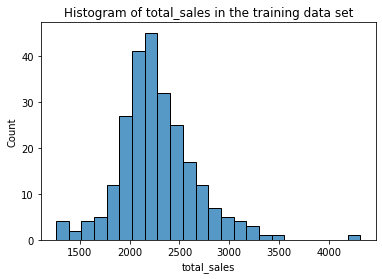

In [ ]:
# Examine the distribution of target variable for training data set
snsplot = sns.histplot(data = target_train)
snsplot.set_title("Histogram of total_sales in the training data set")

Text(0.5, 1.0, 'Histogram of total_sales in the testing data set')

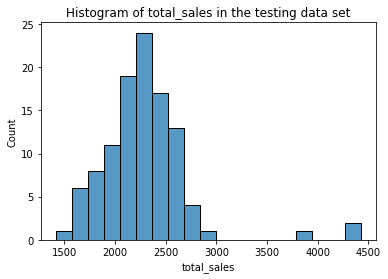

In [ ]:
# Examine the distribution of target variable for testing data set
snsplot = sns.histplot(data = target_test)
snsplot.set_title("Histogram of total_sales in the testing data set")

### 4. Neural network prediction and evaluation

In [ ]:
from scipy.stats.kde import squeeze
# Build a neural network on training data

class extract_tensor(nn.Module):
    def forward(self,x):
        tensor, _ = x
        return tensor[:, -1, :]

class neural_network(nn.Module):
    def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
      super().__init__()
      self.network = nn.Sequential(
          nn.LSTM(in_size, hidden_size1, num_layers=2, batch_first=True),
          extract_tensor(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, out_size))
      
    def forward(self, x):
      out = self.network(x)
      return out.squeeze()

In [ ]:
# Create tensor from pandas dataframe
predictors_train_tensor = torch.tensor(predictors_train.values).view(248, 3, 8) # reshape the tensor to 248 sequences; each sequence has length = 3 and input size = 8 (will be used to predict the next day's sale based on the sales and orders of the past three days)
target_train_tensor = torch.tensor(target_train.values)
predictors_test_tensor = torch.tensor(predictors_test.values).view(107, 3, 8)
target_test_tensor = torch.tensor(target_test.values)

# Create tensor dataset (set target variable to float type)
train_dataset = torch.utils.data.TensorDataset(predictors_train_tensor.float(), target_train_tensor.float())
test_dataset = torch.utils.data.TensorDataset(predictors_test_tensor.float(), target_test_tensor.float())

# Define training and testing data loader, and set batch size to 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Define training loop function
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase 
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs-1 or epoch % 50 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))

In [ ]:
# Model training
torch.manual_seed(0)
model = neural_network(8, 64, 64, 1)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

training_loop(n_epochs= 200, optimizer= optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader)

Epoch 0, Training loss 5341072.84375
Epoch 50, Training loss 362852.4072265625
Epoch 100, Training loss 148971.638671875
Epoch 150, Training loss 147556.25805664062
Epoch 199, Training loss 104499.55517578125


In [ ]:
# Define testing function
def test(model, train_loader, test_loader):
 
  # testing phase
  model.eval()
  predict_train = []
  predict_test = []
  label_train = []
  label_test = []

  with torch.no_grad():
      for inputs, labels in train_loader:
          outputs = model(inputs)
          predict_train.append(outputs.tolist())
          label_train.append(labels.tolist())

      for inputs, labels in test_loader:
          outputs = model(inputs)
          predict_test.append(outputs.tolist())
          label_test.append(labels.tolist())
  
  MAE_train = mean_absolute_error(list(chain(*label_train)), list(chain(*predict_train)))
  RMSE_train = mean_squared_error(list(chain(*label_train)), list(chain(*predict_train)), squared=False)

  MAE_test = mean_absolute_error(list(chain(*label_test)), list(chain(*predict_test)))
  RMSE_test = mean_squared_error(list(chain(*label_test)), list(chain(*predict_test)), squared=False)

  print("Training MAE and RMSE:", MAE_train, RMSE_train)
  print()
  print("testing MAE and RMSE:", MAE_test, RMSE_test)

In [ ]:
# Examine evaluation results
test(model, train_loader, test_loader)

Training MAE and RMSE: 229.50958055065524 319.5616487642847

testing MAE and RMSE: 257.88651910229265 409.00735105155513


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/DL_Lab/Lab10_Learning_from_Squential_Data.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/DL_Lab/Lab10_Learning_from_Squential_Data.ipynb to html
[NbConvertApp] Writing 381951 bytes to /content/drive/MyDrive/DL_Lab/Lab10_Learning_from_Squential_Data.html
